In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\08-01-04_aka_part2_05-01-04_L4_interlaminar ['Old', 'Diagram'] ['08-01-04_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_17.dat', 'LaminarVisual08-01-04.png', 'desktop.ini']
slice 8 , rec 4
edge_pts [[79, 55], [79, 0]] axis_pts [[28, 53], [28, 0]]
laminar axis unit vectors: [0.9992319507315425, 0.039185566695354605] [1.0, 0.0]
ROI centers: [[78.85, 0.58], [78.87, 0.58], [78.88, 0.58], [78.9, 0.59], [78.91, 0.59], [78.93, 0.59], [78.94, 0.59], [78.95, 0.6], [78.96, 0.6], [78.97, 0.6], [78.98, 0.6], [78.98, 0.61], [78.99, 0.61], [78.99, 0.61], [79.0, 0.61], [79.0, 0.62], [79.0, 0.62]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\08-01-04_aka_part2_05-01-04_L4_interlaminar/rois_01_to_17.dat
Stim point: [19, 54]
laminar_distances: [57.71, 57.73, 57.74, 57.76, 57.77, 57.79, 57.8, 57.81, 57.82, 57.83, 57.84, 57.84, 57.85, 57.85, 57.86, 57.86, 57.86]
laminar_distances

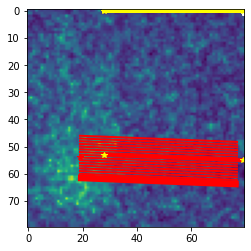

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\10-01-01_aka_part2_07-01-01_L4_interlaminar ['Old', 'Diagram'] ['10-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_14.dat', 'LaminarVisual10-01-01.png', 'desktop.ini']
slice 10 , rec 1
edge_pts [[79, 33], [79, 66]] axis_pts [[37, 63], [34, 33]]
laminar axis unit vectors: [1.0, 0.0] [0.997458699830735, 0.07124704998790965]
ROI centers: [[78.65, 77.81], [78.69, 77.81], [78.74, 77.81], [78.78, 77.81], [78.81, 77.81], [78.84, 77.81], [78.87, 77.81], [78.9, 77.81], [78.92, 77.81], [78.94, 77.81], [78.96, 77.81], [78.98, 77.81], [78.99, 77.81], [78.99, 77.81]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\10-01-01_aka_part2_07-01-01_L4_interlaminar/rois_01_to_14.dat
Stim point: [36, 57]
laminar_distances: [42.65, 42.69, 42.74, 42.78, 42.81, 42.84, 42.87, 42.9, 42.92, 42.94, 42.96, 42.98, 42.99, 42.99]
laminar_distances: [44.02, 44.07, 44.11, 44.15, 44.19, 44.22,

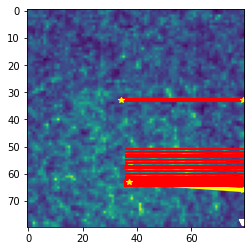

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\06-01-01_aka_part2_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['06-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_14.dat', 'LaminarVisual06-01-01.png', 'rois_01_to_15.dat', 'desktop.ini']
slice 6 , rec 1
edge_pts [[79, 40], [79, 26]] axis_pts [[37, 45], [32, 56]]
laminar axis unit vectors: [0.946649906050144, -0.3222637978043043] [0.9111079228383558, -0.4121678698554467]
ROI centers: [[76.7, 5.78], [76.97, 5.58], [77.23, 5.39], [77.46, 5.2], [77.68, 5.02], [77.88, 4.83], [78.07, 4.65], [78.24, 4.47], [78.39, 4.3], [78.53, 4.13], [78.65, 3.97], [78.75, 3.8], [78.83, 3.64], [78.9, 3.49], [78.95, 3.33]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\06-01-01_aka_part2_03-01-01_L4_interlaminar/rois_01_to_15.dat
Stim point: [33, 54]
laminar_distances: [56.9, 57.23, 57.54, 57.81, 58.09, 58.33, 58.57, 58.79, 58.99, 59.17, 59.34, 59.48, 59.61, 59.73, 59.83]
lamina

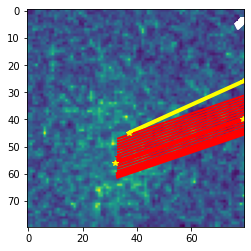

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\03-01-08_aka_02-01-08_L23_intralaminar ['Old', 'Diagram'] ['03-01-08_snr.txt', 'electrode.dat', 'corners_layer.dat', 'rois_01_to_12.dat', 'LaminarVisual03-01-08.png', 'rois_01_to_14.dat', 'desktop.ini']
slice 3 , rec 8
edge_pts [[55, 0], [73, 0]] axis_pts [[40, 47], [29, 36]]
laminar axis unit vectors: [0.5854905538443584, -0.8106792283998809] [0.5746304214759497, -0.8184130245263527]
ROI centers: [[76.9, 1.49], [77.04, 1.29], [77.18, 1.11], [77.32, 0.93], [77.45, 0.78], [77.57, 0.64], [77.69, 0.51], [77.8, 0.4], [77.91, 0.3], [78.02, 0.21], [78.11, 0.14], [78.21, 0.09], [78.3, 0.04], [78.38, 0.02]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\03-01-08_aka_02-01-08_L23_intralaminar/rois_01_to_14.dat
Stim point: [35, 42]
laminar_distances: [57.38, 57.62, 57.85, 58.07, 58.27, 58.45, 58.63, 58.79, 58.93, 59.06, 59.18, 59.28, 59.36, 59.43]
laminar_distances: [57.23, 57.48, 57.71

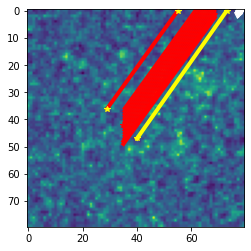

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\04-01-01_aka_03-01-01_L4_interlaminar ['Old', 'Diagram'] ['04-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_07.dat', 'LaminarVisual04-01-01.png', 'rois_01_to_09.dat', 'desktop.ini']
slice 4 , rec 1
edge_pts [[29, 79], [0, 79]] axis_pts [[26, 46], [44, 58]]
laminar axis unit vectors: [-0.5812381937190965, 0.813733471206735] [-0.6188722266035128, 0.7854916722275356]
ROI centers: [[0.81, 78.77], [0.74, 78.82], [0.68, 78.87], [0.63, 78.9], [0.57, 78.94], [0.52, 78.96], [0.47, 78.98], [0.42, 79.0], [0.38, 79.0]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\04-01-01_aka_03-01-01_L4_interlaminar/rois_01_to_09.dat
Stim point: [29, 48]
laminar_distances: [41.42, 41.5, 41.57, 41.64, 41.7, 41.75, 41.79, 41.83, 41.86]
laminar_distances: [41.61, 41.69, 41.77, 41.83, 41.89, 41.95, 41.99, 42.03, 42.06]


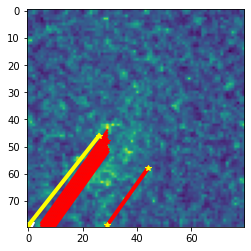

G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\11-01-06_aka_part2_08-01-06_L4_interlaminar ['Old', 'Diagram'] ['11-01-06_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'rois_01_to_16.dat', 'desktop.ini']
slice 11 , rec 6
edge_pts [[31, 0], [16, 0]] axis_pts [[19, 50], [34, 50]]
laminar axis unit vectors: [-0.05989229072794672, -0.9982048454657786] [-0.05989229072794672, -0.9982048454657786]
ROI centers: [[2.24, 1.81], [2.22, 1.6], [2.19, 1.4], [2.17, 1.21], [2.15, 1.04], [2.12, 0.88], [2.1, 0.73], [2.08, 0.6], [2.06, 0.48], [2.03, 0.37], [2.01, 0.28], [1.99, 0.2], [1.97, 0.13], [1.94, 0.08], [1.92, 0.04], [1.9, 0.01]]
Created file: G:/.shortcut-targets-by-id/1agT5mnPWaZdQIB8nNNVWaVbqpbYNGxcB\2020-12-28\11-01-06_aka_part2_08-01-06_L4_interlaminar/rois_01_to_16.dat
Stim point: [23, 50]
laminar_distances: [49.34, 49.56, 49.76, 49.95, 50.12, 50.28, 50.43, 50.56, 50.68, 50.79, 50.89, 50.97, 51.04, 51.09, 51.13, 51.16]
laminar_distances: [49.34, 49.56, 49.76, 49.95

Stim point: [41, 27]
laminar_distances: [51.14, 51.24, 51.33, 51.41, 51.49, 51.56, 51.63, 51.69, 51.74, 51.8, 51.84, 51.88, 51.91, 51.94, 51.97, 51.98, 51.99]
laminar_distances: [51.14, 51.24, 51.33, 51.41, 51.49, 51.56, 51.63, 51.69, 51.74, 51.8, 51.84, 51.88, 51.91, 51.94, 51.97, 51.98, 51.99]
G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\09-01-01_L23_interlaminar ['Old', 'Diagram'] ['09-01-01_snr.txt', 'electrode.dat', 'corners_barrel.dat', 'desktop.ini']
slice 9 , rec 1
edge_pts [[48, 79], [29, 79]] axis_pts [[27, 34], [44, 34]]
laminar axis unit vectors: [0.08853979028379436, 0.9960726406926864] [0.04440061362072038, 0.9990138064662086]
ROI centers: [[4.67, 77.86], [4.73, 78.01], [4.79, 78.15], [4.84, 78.27], [4.9, 78.39], [4.96, 78.5], [5.01, 78.6], [5.07, 78.68], [5.13, 78.76], [5.19, 78.82], [5.25, 78.88], [5.31, 78.92], [5.37, 78.96], [5.43, 78.98], [5.49, 79.0]]
Created file: G:/.shortcut-targets-by-id/1aiA17l3WSNA3lJrBRw6fZUtC8pb2V6sS\2021-01-11\09-

<Figure size 432x288 with 0 Axes>

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/Kate's/ROI_dist/"
data_dir = "G:/.shortcut-targets-by-id/"
corners_file_prefix_layer = 'corners_layer'
corners_file_prefix_barrel = 'corners_barrel'
electrode_file_prefix = 'electrode'
rois_file_prefix = 'rois' # e.g. 'rois_01_to_09.dat'
snr_file_prefix = 'SNR'

image_data = {}
n_plots = 5  # how many to show

for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > 4:  # don't care about any deeper dir
        continue
    if 'notUsable' in subdir:
        continue
    if depth == 4:
        print(subdir, dirs, files)
    subdir += '/'
    for filename in files:
        if filename.split(".")[0].endswith("_snr"):
            name_parse = filename[:8]  # of the format 07_01_01
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('-')]
            except ValueError:
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))

            print("slice", slic, ", rec", rec)

            # open corners, interlaminar, 2 points p1, p2 to define the edge along which to measure
            
            for la_file in [subdir + corners_file_prefix_layer + '.dat', 
                            subdir + corners_file_prefix_barrel + '.dat']:
                lines = None
                if os.path.exists(la_file):
                    with open(la_file, 'r') as f:
                        lines = f.readlines() 
                    corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                    layer_axes = LayerAxes(corners)
                    laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                    print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                          laminar_axis_2.get_unit_vector())

                    # make our own ROIs from the list of edges and write them to a .dat file
                    roi_cr = ROICreator(layer_axes)
                    rois = roi_cr.get_rois()  # list of list of points
                    #   rois = ROIFileReader(rois_file).get_roi_list()
                    roi_centers = [r.get_center() for r in rois]
                    roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
                    print("ROI centers:", roi_centers)
                    
                    # write these ROIs to file
                    roi_cr.write_roi_file(subdir, rois_file_prefix)

                    # open stim point roi as a single integer (its diode number) in variable stim_pt
                    sp_file = subdir + electrode_file_prefix + '.dat'
                    with open(sp_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)

                    # run laminar dist computation
                    laminar_distances = LaminarDistance(laminar_axis, rois, stim_pt).compute_laminar_distances()
                    laminar_distances = [round(ld, 2) for ld in laminar_distances]
                    print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                    # run laminar dist again with the other axis
                    laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                    laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                    print('laminar_distances:', laminar_distances_2)  # a list of integers with same indexing as rois

                    image_data[slic][loc][rec] = {
                        'snr': snr,
                        'filename': filename,
                        'laminar_distances': laminar_distances}

                    # Now that the data is stored, show intermediate computations in plot
                    if n_plots > 0:
                        lines = [laminar_axis.get_line_repr(),
                                 laminar_axis_2.get_line_repr()]
                        line_colors = ['red', 'yellow']
                        linewidths = [4,4,4,4]
                        other_colors = ['red']

                        # laminar aux lines
                        uv = laminar_axis.get_unit_vector()
                        for i in range(len(laminar_distances)):
                            ld = laminar_distances[i]
                            jiggle = i - int(len(laminar_distances) / 2)
                            stim_proxy_pt = [stim_pt[0], stim_pt[1] - jiggle]
                            measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                            lines.append([measure_vector, stim_proxy_pt])
                            line_colors.append(other_colors[i % len(other_colors)])
                            linewidths.append(2)

                        LaminarVisualization(snr, 
                                             stim_pt, 
                                             roi_centers, 
                                             layer_axes.get_corners(),
                                             lines,
                                             line_colors,
                                             linewidths,
                                             save_dir=subdir+"LaminarVisual"+name_parse+'.png')
                        n_plots -= 1
